In [1]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [2]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==4:
    target='delv24'
elif int(config_set['target_lag'])==8:
    target='delv48'
seeds = np.arange(100,130,1)

In [3]:
var_names = performance_scores.scores_seeds(seed=100,target=target,
                                            lag=int(config_set['target_lag']),
                                            exp='SHIPSERA5_noassum',
                                           prefix='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/SHIPS/2024_causalML_results/results/',
                                           suffix=None).read_stored(exp='SHIPSERA5_noassum')['var_names']

# No causal selection

In [7]:
score_nocausal = []
for seed in tqdm(seeds):
    nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]


In [8]:
r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]

In [12]:
np.asarray(r2_train_noFS).max(),np.asarray(r2_valid_noFS).max(),np.asarray(r2_test_noFS).max()

(0.2508884926195001, 0.16846105741029127, 0.2299550853890877)

In [48]:
np.asarray(r2_train_noFS).mean(),np.asarray(r2_valid_noFS).mean(),np.asarray(r2_test_noFS).mean()

(0.23974486224659045, -0.3835245560810113, -0.4198396495504194)

# With causal

In [4]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,
                                                     target=target,
                                                     lag=int(config_set['target_lag']),
                                                     exp='SHIPSERA5_noassum',
                                                    prefix='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/SHIPS/2024_causalML_results/results/',
                                                    suffix=None).run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])

In [6]:
np.asarray(r2_valid_causalFS[0]).argmax()

14

## Find variable lists

In [8]:
def find_best_var_per_seed(r2,score_causal):
    causal_varlists = []
    for i in range(len(score_causal)):
        causal_varlists.append(score_causal[i][np.asarray(r2[i]).argmax()]['corrrank'])
    return causal_varlists

def count_all_varlists(varlists):
    from collections import Counter
    from functools import reduce
    freq = list(map(Counter, varlists)) 
    res = {ele: [cnt[ele] for cnt in freq] for ele in {ele for cnt in freq for ele in cnt}}
    
    dict1 = res
    for k, v in dict1.items():
        dict1[k] = reduce(lambda a, b: a+b, v)
    return pd.Series((dict1))

In [9]:
causal_varlists = find_best_var_per_seed(r2_valid_causalFS,score_causal)
count_causallists = count_all_varlists(causal_varlists)

In [10]:
count_causallists.sort_values(ascending=False)[:20]

clat               29
shear_1000_850     25
outrhum_400        24
outpvor_500        22
wind10             21
outdiv_100         17
twnd850            13
div_0_1000_150     13
pmin               12
outdiv_1000        10
outvvel_200         9
mw_vvel_200_800     7
div_100             7
vvel_1000           5
temp_150            4
outeqt200           4
outvort_1000        4
vort_400            4
shear_850_200.1     3
pvor_100            3
dtype: int64

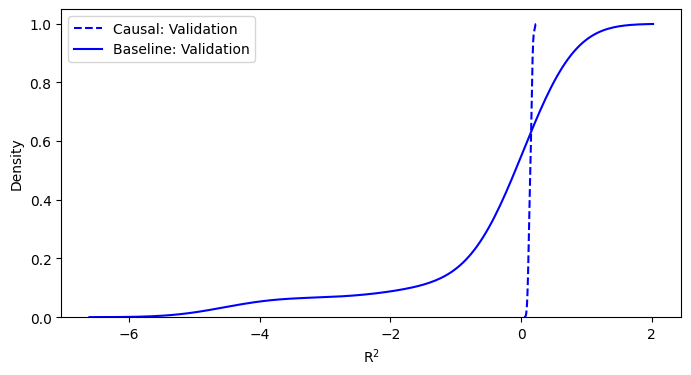

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
#sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',c='k',label='Causal: Train',ax=ax)
#sns.kdeplot((r2_train_noFS),c='k',ls='-',label='Baseline: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_valid_causalFS)),ls='--',c='b',label='Causal: Validation',ax=ax,cumulative=True)
sns.kdeplot((r2_valid_noFS),c='b',ls='-',label='Baseline: Validation',ax=ax,cumulative=True)
#sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',c='r',label='Causal: Test',ax=ax,cumulative=True)
#sns.kdeplot((r2_test_noFS),c='r',ls='-',label='Baseline: Test',ax=ax,cumulative=True)
plt.legend(loc=2)
plt.xlabel('R$^2$')
#plt.xlim(-6,6)
#plt.savefig('./figures/SHIPSonly_r2.png',dpi=600)
plt.show()

In [35]:
np.asarray(miss.flatten(r2_train_causalFS)).max(),np.asarray(miss.flatten(r2_valid_causalFS)).max(),np.asarray(miss.flatten(r2_test_causalFS)).max()

(0.21499643179289152, 0.2142942615605763, 0.15818328279547011)

In [46]:
np.asarray(miss.flatten(r2_train_causalFS)).mean(),np.asarray(miss.flatten(r2_valid_causalFS)).mean(),np.asarray(miss.flatten(r2_test_causalFS)).mean()

(0.18150755160328977, 0.14086613176881835, 0.12248887975611947)

## With Correlation

In [75]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,
                                                          lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').run_score_corrFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:47<00:00, 15.57s/it]


In [76]:
r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)

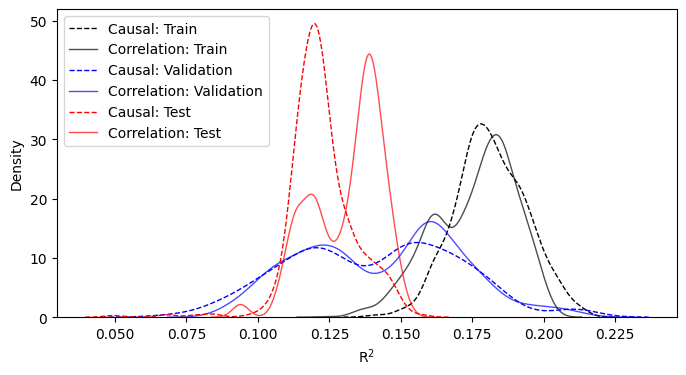

In [80]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
sns.kdeplot(np.asarray(miss.flatten(r2_train_causalFS)),ls='--',lw=1,c='k',label='Causal: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_train_corrFS)),c='k',ls='-',lw=1,alpha=0.7,label='Correlation: Train',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_valid_causalFS)),ls='--',lw=1,c='b',label='Causal: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_valid_corrFS)),c='b',ls='-',lw=1,alpha=0.7,label='Correlation: Validation',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_test_causalFS)),ls='--',lw=1,c='r',label='Causal: Test',ax=ax)
sns.kdeplot(np.asarray(miss.flatten(r2_test_corrFS)),c='r',ls='-',lw=1,alpha=0.7,label='Correlation: Test',ax=ax)
plt.legend(loc=2)
plt.xlabel('R$^2$')
#plt.xlim(-0.5,0.5)
#plt.savefig('./figures/SHIPSonly_r2_corr.png',dpi=600)
plt.show()

In [221]:
score_correlation[21]['corrrank'][:10]

wind10              0.382635
pmin                0.176369
out_t250            0.013019
out_t200            0.072456
spdx                0.011848
out_mean_midrhum    0.083199
POT                 0.313613
POT2                0.328536
PER                 0.044351
VPER                0.060067
dtype: float64

In [222]:
score_causal[21][7]['corrrank']

['wind10', 'clat', 'sdir', 'mw_vvel_200_800', 'pc20', 'div_200', 'shearmag']

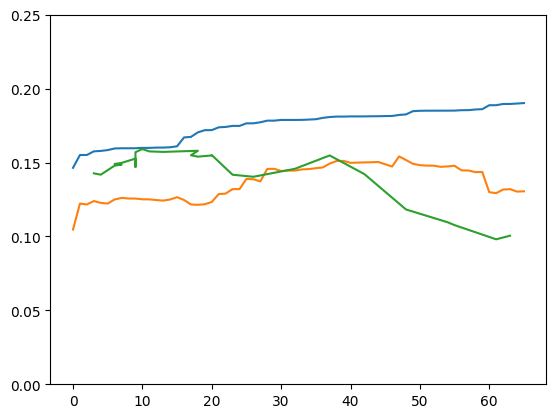

In [220]:
i=21
plt.plot(r2_train_corrFS[i])
plt.plot(r2_valid_corrFS[i])
plt.plot(shapez_causalFS[i],r2_valid_causalFS[i])
plt.ylim(0,0.25)
plt.show()

In [72]:
score_causal[29][

68

In [214]:
import importlib
importlib.reload(performance_scores)

<module 'util.models.performance_scores' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/2024_causalML/util/models/performance_scores.py'>